In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier


cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                            test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std
x_val_scaled = (x_val - train_mean) / train_std
                                                  

In [4]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b    # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err          # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())       # 가중치를 기록합니다.
        np.random.seed(42)                         # 랜덤 시드를 지정합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다.
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                # 그래디언트에서 페널티 항의 미분 값을 더합니다
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad         # 가중치 업데이트
                self.b -= b_grad                   # 절편 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y) + self.reg_loss())
            # 검증 세트에 대한 손실을 계산합니다
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) >= 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])     # 정방향 계산
            a = self.activation(z)         # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

# 5_3 규제 방법을 배우고 단일층 신경망에 적용


In [5]:
# 1. 그레이디언트 업데이트 수식에 페널티 항 반영하기

def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_loses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

In [6]:
# 2. fit 메서드 역방향 계싼 수행시 그레이디언트에 페넡리 항의 미분값을 더한다. 
# L1, L2 규제 동시에 가능 

def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())       # 가중치를 기록합니다.
        np.random.seed(42)                         # 랜덤 시드를 지정합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다.
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                # 그래디언트에서 페널티 항의 미분 값을 더합니다
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad         # 가중치 업데이트
                self.b -= b_grad                   # 절편 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y) + self.reg_loss())
            # 검증 세트에 대한 손실을 계산합니다
            self.update_val_loss(x_val, y_val)
    

In [7]:
# 3. 로지스틱 손실 함수 계산에 페넡티 항 추가하기
# 페널티 항에 대한 값 더해야 한다. reg_loss()메서드 추가
def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    

In [8]:
# 4. 검증 세트 손실 계산하는 update_val_loss() 메서드에 reg_loss () 호출 설정
def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])     # 정방향 계산
            a = self.activation(z)         # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

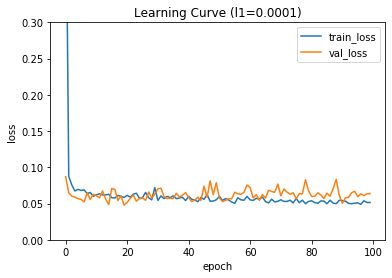

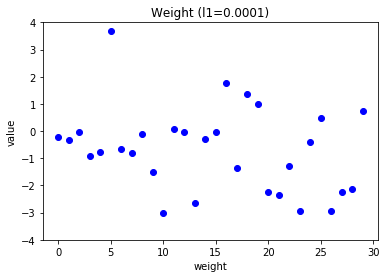

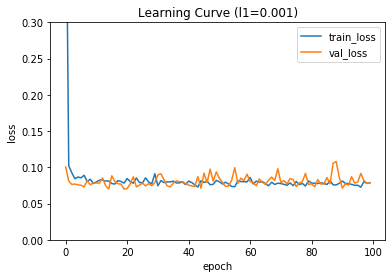

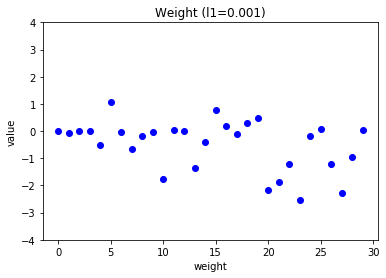

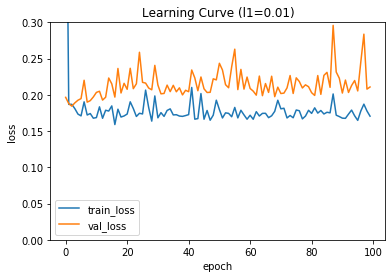

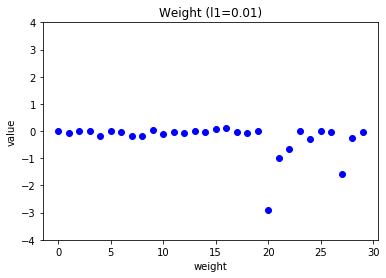

In [9]:
# 5. cancer 데이터 세트에 L1 규제 적용
# 규제 강도 0.0001, 0.001, 0.01 규제 강도에 따라 모델의 학습 곡선과 가중치 어떻게 바뀌는지 확인
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val =y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l1={})'.format(l1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l1={})'.format(l1))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()


In [10]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled,y_val) #0.978~
# 규제 적용하지 않고 검증 세트 성능 평가와 같다

0.978021978021978

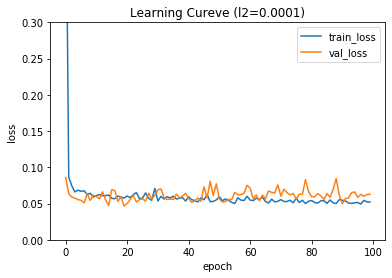

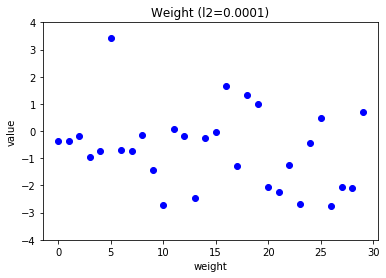

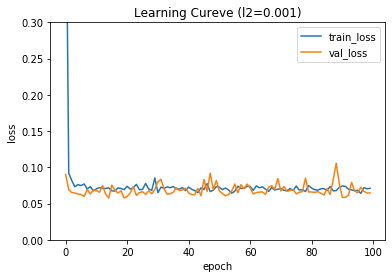

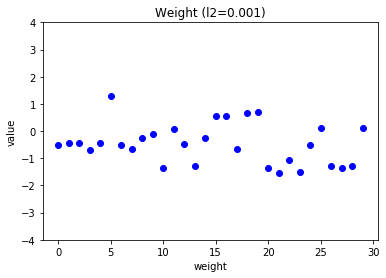

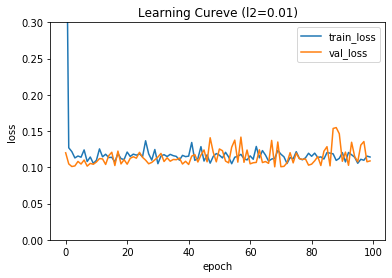

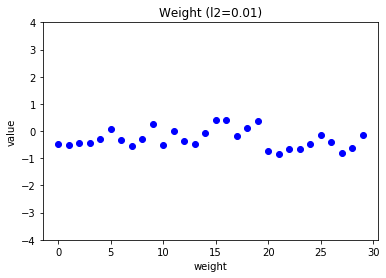

In [11]:
# 6. cancer 데이터 세트에 L2 규제 적용

l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Cureve (l2={})'.format(l2))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss','val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l2={})'.format(l2))
    plt.xlabel('weight')
    plt.ylabel('value')
    plt.ylim(-4, 4)
    plt.show()
    

In [12]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val) # 0.978 
# L1 규제와 동일
# cancer 데이터 샘플이 적어서 큰 차이가 없다.


0.978021978021978

In [13]:
np.sum(layer6.predict(x_val_scaled) == y_val) # 91개 검증 샘플 중 89개 옳게 예측

# L1 규제보다 에포크가 크게 늘어남 L1 ㄱ제시 20번 에포크 - L2 규제 50번의 에포크
# 가중치 강하게 제한해서 검증 세트의 손실값을 일절 수준으로 유지하면서 알고리즘이 전역 최솟갑승ㄹ 찾는 과정 오래 반복가능


89

In [14]:
# 7. SGDClassifier 에서 규제 사용

sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)


0.978021978021978

In [15]:
# 1. 훈련 세트 사용하기
validation_scores = []


In [18]:
# 2. k-폴드 교차 검증 구현

k = 10 
bins = len(x_train_all) // k

for i in range(k):
    start = i*bins
    end = (i+1)*bins
    val_fold = x_train_all[start:end]
    val_target = y_train_all[start:end]
    
    train_index = list(range(0, start)) + list(range(end, len(x_train)))
    train_fold = x_train_all[train_index]
    train_target = y_train_all[train_index]
    
    train_mean = np.mean(train_fold, axis = 0)
    train_std = np.std(train_fold, axis=0)
    train_fold_scaled = (train_fold -train_mean) /train_std
    val_fold_scaled = (val_fold - train_mean)/train_std
    
    lyr = SingleLayer(l2=0.01)
    lyr.fit(train_fold_scaled, train_target, epochs=50)
    score=lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)
    
print(np.mean(validation_scores))


0.9668518518518519


In [19]:
# 사이킷런으로 교차 검증

from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)
print(np.mean(scores['test_score']))
# 표준화 전처리를 수행하지 않아 평균 점수 85%로 낮다.

0.850096618357488


In [21]:
# Pipeline 클래스 사용해 교차 검증 수행

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724


In [22]:
print(np.mean(scores['train_score']))


0.9875478561631581
